<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad_Feb22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [2]:
#import math

import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


# Funciones

In [3]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura de datos

In [4]:
file = 'C:\\Users\\conte\\OneDrive\\Escritorio\\Colegio Bourbaki\\SeriesTiempo\\Prediccion-produccion-electricidad-main\\Datos\\TD_S_SescoWebUP_07_2022.csv'
datos = pd.read_csv(file)
datos


,Date,TotalPet,TotalGas
0,1/1/2009,97924.5991,135493.2462
1,2/1/2009,100044.0659,119567.3700
2,3/1/2009,99329.5204,132671.8891
3,4/1/2009,98880.3859,116012.7545
4,5/1/2009,98151.9991,108534.5693
...,...,...,...
158,3/1/2022,89459.4248,144416.8986
159,4/1/2022,90490.6676,124820.8609
160,5/1/2022,91589.1089,117977.1775
161,6/1/2022,91155.8765,121233.9448


In [5]:
datos["Date"] = pd.to_datetime(datos["Date"])

datos = datos.set_index('Date')


In [6]:
datos.round(3)
datos.describe()

,TotalPet,TotalGas
count,163.000000,163.000000
mean,84443.916705,123918.355905
std,6495.752824,7495.472834
min,71163.538400,105860.819600
25%,79468.451400,117651.243200
50%,84406.510100,123464.276900
75%,88486.056450,128298.842800
max,100044.065900,144420.969600


In [7]:
# revisamos si las fechas están ordenads
datos.index.is_monotonic

True

In [8]:
datos.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='Date', length=163, freq=None)

In [9]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='Date', length=163, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

# Exploración y Visualización de la Serie Temporal

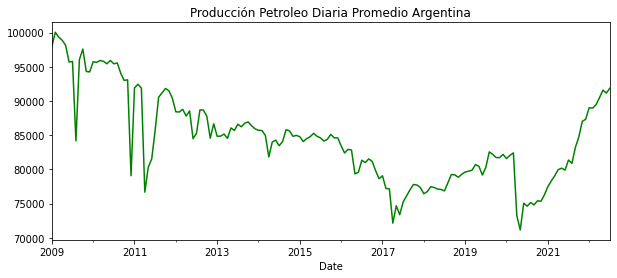

In [75]:
datos['TotalPet'].plot(figsize=(10,4), title='Producción Petroleo Diaria Promedio Argentina', color='green')
plt.show()

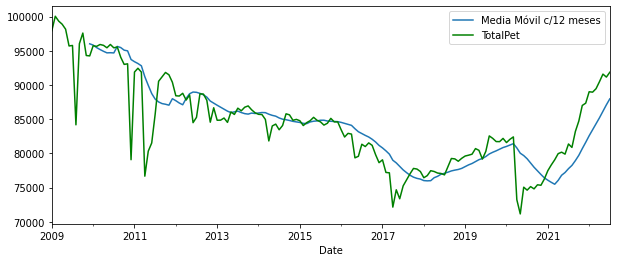

In [76]:
datos['TotalPet'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['TotalPet'].plot(color='green')
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

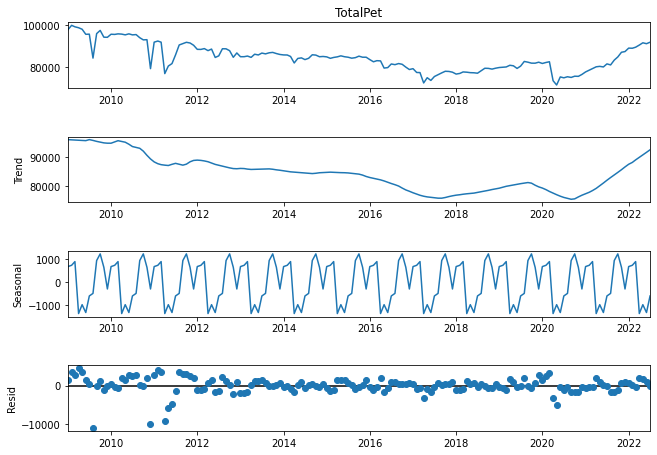

In [12]:
decomp = seasonal_decompose(datos['TotalPet'], period=12, extrapolate_trend='freq')
fig = decomp.plot()
fig.set_size_inches(10,7)

# Convertir los datos a Estacionarios

Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [13]:
pValue = adfuller(datos['TotalPet'])[1]
pValue

0.16929624800270643

In [14]:
p_value_adfuller(datos['TotalPet'])

P-value:  0.16929624800270643
No se rechaza la hipóteis nula, los datos no son estacionarios


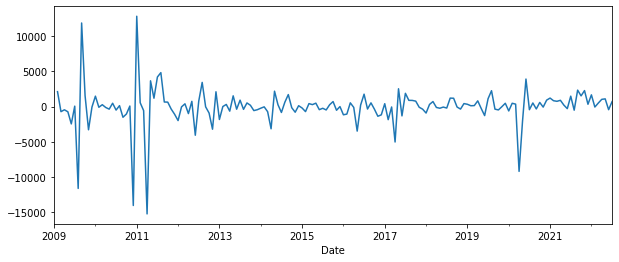

In [16]:
datos['1a diff']= datos['TotalPet'] - datos['TotalPet'].shift(1) 
datos['1a diff'].plot(figsize=(10,4))
plt.show()

In [77]:
p_value_adfuller((datos['1a diff']).dropna())

P-value:  1.2919028643504744e-18
Se rechaza la hipótesis nula, los datos son estacionarios


# Visualización de la ACF y PACF

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


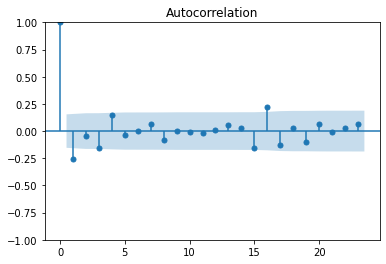

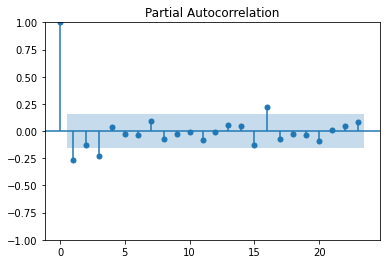

In [78]:
plot_acf(datos['1a diff'].dropna())
plot_pacf(datos['1a diff'].dropna())
plt.show()

# Construcción del modelo SARIMA



In [107]:
train = datos.loc[:'2022-1-1','TotalPet']
test = datos.loc['2022-1-1':,'TotalPet']

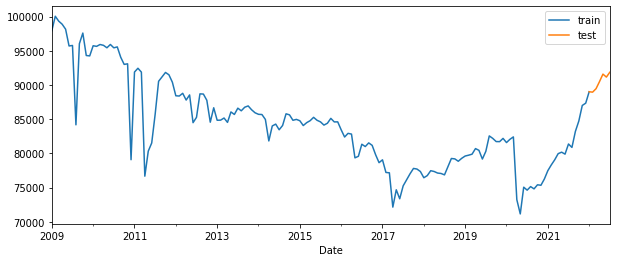

In [108]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

In [112]:
len(test)/len(train)

0.044585987261146494

In [109]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [110]:
p = d =  q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [111]:
aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(datos.loc[:'2021-12-1','TotalPet'],
                       order = parametros,
                       seasonal_order = parametros_s,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
      results = modelo.fit()#method_kwargs={"warn_convergence": False}
      aic_modelos[parametros, parametros_s] = results.aic
      print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))  

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC:3958.059295848826
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC:115950.17628010738


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC:3436.222160272049
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC:2853.253488436051
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC:2571.048095783884
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC:2324.8583959148764
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC:2731.1429081882497
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC:2419.5685265190764
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC:2168.922045593548
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC:2863.028955881473
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC:2853.6401834596363
ARIMA(0, 0, 0) x (1, 0, 2, 12) - AIC:2565.0881423694454
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC:2617.06902219944
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC:2627.720129714871
ARIMA(0, 0, 0) x (1, 1, 2, 12) - AIC:2319.9640760815237
ARIMA(0, 0, 0) x (1, 2, 0, 12) - AIC:2430.3927238049127
ARIMA(0, 0, 0) x (1, 2, 1, 12) - AIC:2401.8112776784633
ARIMA(0, 0, 0) x (1, 2, 2, 12) - AIC:2150.556308633576
ARIMA(0, 0, 0) x (2, 0, 0, 12) - AIC:2594.379397056321
ARIMA(0, 0, 0) x (2, 0, 1, 12) - AIC:2576.786433495177
ARI

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2) x (1, 1, 2, 12) - AIC:2158.1472743694226
ARIMA(0, 0, 2) x (1, 2, 0, 12) - AIC:2385.581269916827
ARIMA(0, 0, 2) x (1, 2, 1, 12) - AIC:2317.4775246670115
ARIMA(0, 0, 2) x (1, 2, 2, 12) - AIC:2005.2144153071765
ARIMA(0, 0, 2) x (2, 0, 0, 12) - AIC:3245.2287299753502
ARIMA(0, 0, 2) x (2, 0, 1, 12) - AIC:3247.2270363797397
ARIMA(0, 0, 2) x (2, 0, 2, 12) - AIC:3175.6966384808466
ARIMA(0, 0, 2) x (2, 1, 0, 12) - AIC:2234.7163156366205
ARIMA(0, 0, 2) x (2, 1, 1, 12) - AIC:2233.897808505255
ARIMA(0, 0, 2) x (2, 1, 2, 12) - AIC:2154.136619700971
ARIMA(0, 0, 2) x (2, 2, 0, 12) - AIC:2133.041021508375
ARIMA(0, 0, 2) x (2, 2, 1, 12) - AIC:2062.077230385171
ARIMA(0, 0, 2) x (2, 2, 2, 12) - AIC:1994.0398395128686
ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC:2887.3148605878114
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC:2636.8864738856655
ARIMA(0, 1, 0) x (0, 0, 2, 12) - AIC:2362.944170371855
ARIMA(0, 1, 0) x (0, 1, 0, 12) - AIC:2752.083374078469
ARIMA(0, 1, 0) x (0, 1, 1, 12) - AIC:2461.6063942622113

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0) x (2, 2, 0, 12) - AIC:1999.0719121380587
ARIMA(0, 1, 0) x (2, 2, 1, 12) - AIC:1946.197762488687
ARIMA(0, 1, 0) x (2, 2, 2, 12) - AIC:1931.7923111085013
ARIMA(0, 1, 1) x (0, 0, 0, 12) - AIC:2855.851034379003
ARIMA(0, 1, 1) x (0, 0, 1, 12) - AIC:2612.4085073478436
ARIMA(0, 1, 1) x (0, 0, 2, 12) - AIC:2347.398577655341
ARIMA(0, 1, 1) x (0, 1, 0, 12) - AIC:2721.2415265724408
ARIMA(0, 1, 1) x (0, 1, 1, 12) - AIC:2450.7071192206895
ARIMA(0, 1, 1) x (0, 1, 2, 12) - AIC:2123.8144026671434
ARIMA(0, 1, 1) x (0, 2, 0, 12) - AIC:2613.1597436927955
ARIMA(0, 1, 1) x (0, 2, 1, 12) - AIC:2213.57904325154
ARIMA(0, 1, 1) x (0, 2, 2, 12) - AIC:2039.3169413533603
ARIMA(0, 1, 1) x (1, 0, 0, 12) - AIC:2649.554418349545
ARIMA(0, 1, 1) x (1, 0, 1, 12) - AIC:2603.2285448281564
ARIMA(0, 1, 1) x (1, 0, 2, 12) - AIC:2346.7738606218963
ARIMA(0, 1, 1) x (1, 1, 0, 12) - AIC:2481.0534395584664
ARIMA(0, 1, 1) x (1, 1, 1, 12) - AIC:2432.658482949701


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1) x (1, 1, 2, 12) - AIC:2123.8837856858904
ARIMA(0, 1, 1) x (1, 2, 0, 12) - AIC:2346.439052618453
ARIMA(0, 1, 1) x (1, 2, 1, 12) - AIC:2192.6491170203285


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1) x (1, 2, 2, 12) - AIC:1921.0386062844102
ARIMA(0, 1, 1) x (2, 0, 0, 12) - AIC:2381.941292921348
ARIMA(0, 1, 1) x (2, 0, 1, 12) - AIC:2379.9195914931024
ARIMA(0, 1, 1) x (2, 0, 2, 12) - AIC:2347.1853717153476
ARIMA(0, 1, 1) x (2, 1, 0, 12) - AIC:2152.4098398050714
ARIMA(0, 1, 1) x (2, 1, 1, 12) - AIC:2154.235985345681
ARIMA(0, 1, 1) x (2, 1, 2, 12) - AIC:2114.581590507056
ARIMA(0, 1, 1) x (2, 2, 0, 12) - AIC:1999.4972886532585
ARIMA(0, 1, 1) x (2, 2, 1, 12) - AIC:1945.3162493336642
ARIMA(0, 1, 1) x (2, 2, 2, 12) - AIC:2041.9031070327624
ARIMA(0, 1, 2) x (0, 0, 0, 12) - AIC:2839.982069043632
ARIMA(0, 1, 2) x (0, 0, 1, 12) - AIC:2594.780485191186
ARIMA(0, 1, 2) x (0, 0, 2, 12) - AIC:2264.3259575922934
ARIMA(0, 1, 2) x (0, 1, 0, 12) - AIC:2703.457135631539
ARIMA(0, 1, 2) x (0, 1, 1, 12) - AIC:2409.030867670038
ARIMA(0, 1, 2) x (0, 1, 2, 12) - AIC:2097.165390601034
ARIMA(0, 1, 2) x (0, 2, 0, 12) - AIC:2590.6627440672646
ARIMA(0, 1, 2) x (0, 2, 1, 12) - AIC:2148.057814739457
A

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2) x (2, 2, 2, 12) - AIC:1902.4384327374223
ARIMA(0, 2, 0) x (0, 0, 0, 12) - AIC:3011.2981319023393
ARIMA(0, 2, 0) x (0, 0, 1, 12) - AIC:2744.5528537453783
ARIMA(0, 2, 0) x (0, 0, 2, 12) - AIC:2440.703522737953
ARIMA(0, 2, 0) x (0, 1, 0, 12) - AIC:2864.877307345622
ARIMA(0, 2, 0) x (0, 1, 1, 12) - AIC:2548.6687965771407
ARIMA(0, 2, 0) x (0, 1, 2, 12) - AIC:2226.5583482987126
ARIMA(0, 2, 0) x (0, 2, 0, 12) - AIC:2741.3226593854315
ARIMA(0, 2, 0) x (0, 2, 1, 12) - AIC:2303.8546493570984
ARIMA(0, 2, 0) x (0, 2, 2, 12) - AIC:2061.866439796688
ARIMA(0, 2, 0) x (1, 0, 0, 12) - AIC:2762.9876430084887
ARIMA(0, 2, 0) x (1, 0, 1, 12) - AIC:2721.611765832639
ARIMA(0, 2, 0) x (1, 0, 2, 12) - AIC:2442.465702245261
ARIMA(0, 2, 0) x (1, 1, 0, 12) - AIC:2560.406430507601
ARIMA(0, 2, 0) x (1, 1, 1, 12) - AIC:2543.584261336404
ARIMA(0, 2, 0) x (1, 1, 2, 12) - AIC:2226.825834875161
ARIMA(0, 2, 0) x (1, 2, 0, 12) - AIC:2393.6255734181755
ARIMA(0, 2, 0) x (1, 2, 1, 12) - AIC:2290.3029671315594


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 0) x (2, 0, 2, 12) - AIC:2440.7298535148084
ARIMA(0, 2, 0) x (2, 1, 0, 12) - AIC:2230.741552337678
ARIMA(0, 2, 0) x (2, 1, 1, 12) - AIC:2232.6158874094904
ARIMA(0, 2, 0) x (2, 1, 2, 12) - AIC:2216.2304221605214
ARIMA(0, 2, 0) x (2, 2, 0, 12) - AIC:2071.0014013001214
ARIMA(0, 2, 0) x (2, 2, 1, 12) - AIC:2023.6251937743116
ARIMA(0, 2, 0) x (2, 2, 2, 12) - AIC:2004.361930788624
ARIMA(0, 2, 1) x (0, 0, 0, 12) - AIC:2927.9437648785615
ARIMA(0, 2, 1) x (0, 0, 1, 12) - AIC:2619.736535327341
ARIMA(0, 2, 1) x (0, 0, 2, 12) - AIC:2281.258591705021
ARIMA(0, 2, 1) x (0, 1, 0, 12) - AIC:2769.4824055278737
ARIMA(0, 2, 1) x (0, 1, 1, 12) - AIC:2460.3342986008083
ARIMA(0, 2, 1) x (0, 1, 2, 12) - AIC:2101.489994271818
ARIMA(0, 2, 1) x (0, 2, 0, 12) - AIC:2621.106368431688
ARIMA(0, 2, 1) x (0, 2, 1, 12) - AIC:2299.150160506997
ARIMA(0, 2, 1) x (0, 2, 2, 12) - AIC:1938.5243582814146
ARIMA(0, 2, 1) x (1, 0, 0, 12) - AIC:2655.5014743922648
ARIMA(0, 2, 1) x (1, 0, 1, 12) - AIC:2621.0926347302666

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1) x (1, 1, 2, 12) - AIC:2101.5207145455724
ARIMA(0, 2, 1) x (1, 2, 0, 12) - AIC:2330.0975533600113
ARIMA(0, 2, 1) x (1, 2, 1, 12) - AIC:2299.1499313514532
ARIMA(0, 2, 1) x (1, 2, 2, 12) - AIC:2055.8444506798096
ARIMA(0, 2, 1) x (2, 0, 0, 12) - AIC:2405.555060538043


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1) x (2, 0, 1, 12) - AIC:2365.833526337281
ARIMA(0, 2, 1) x (2, 0, 2, 12) - AIC:2271.9479736218573
ARIMA(0, 2, 1) x (2, 1, 0, 12) - AIC:2240.0698267924545
ARIMA(0, 2, 1) x (2, 1, 1, 12) - AIC:2239.260235862629


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1) x (2, 1, 2, 12) - AIC:2150.801532510547
ARIMA(0, 2, 1) x (2, 2, 0, 12) - AIC:2101.3324787518336


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1) x (2, 2, 1, 12) - AIC:1978.5584721884948
ARIMA(0, 2, 1) x (2, 2, 2, 12) - AIC:2057.735016536431
ARIMA(0, 2, 2) x (0, 0, 0, 12) - AIC:2874.3391916906703
ARIMA(0, 2, 2) x (0, 0, 1, 12) - AIC:2586.8290147290845
ARIMA(0, 2, 2) x (0, 0, 2, 12) - AIC:2255.0585838985444
ARIMA(0, 2, 2) x (0, 1, 0, 12) - AIC:2739.7383955458445
ARIMA(0, 2, 2) x (0, 1, 1, 12) - AIC:2423.706673617918
ARIMA(0, 2, 2) x (0, 1, 2, 12) - AIC:2084.9608640761835
ARIMA(0, 2, 2) x (0, 2, 0, 12) - AIC:2607.0298688104103
ARIMA(0, 2, 2) x (0, 2, 1, 12) - AIC:2167.574831051167
ARIMA(0, 2, 2) x (0, 2, 2, 12) - AIC:2025.9770839893304
ARIMA(0, 2, 2) x (1, 0, 0, 12) - AIC:2640.058308762032
ARIMA(0, 2, 2) x (1, 0, 1, 12) - AIC:2588.7641388129314


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2) x (1, 0, 2, 12) - AIC:2255.8365743233576
ARIMA(0, 2, 2) x (1, 1, 0, 12) - AIC:2493.7799447210004
ARIMA(0, 2, 2) x (1, 1, 1, 12) - AIC:2424.8781147525383


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2) x (1, 1, 2, 12) - AIC:2080.803199395986
ARIMA(0, 2, 2) x (1, 2, 0, 12) - AIC:2371.399389748433
ARIMA(0, 2, 2) x (1, 2, 1, 12) - AIC:2269.043370628835
ARIMA(0, 2, 2) x (1, 2, 2, 12) - AIC:2027.9256547883383
ARIMA(0, 2, 2) x (2, 0, 0, 12) - AIC:2390.551851413319
ARIMA(0, 2, 2) x (2, 0, 1, 12) - AIC:2365.3150291258553


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2) x (2, 0, 2, 12) - AIC:2250.8505737016562


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2) x (2, 1, 0, 12) - AIC:2166.9760459882923
ARIMA(0, 2, 2) x (2, 1, 1, 12) - AIC:2220.766444196005


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2) x (2, 1, 2, 12) - AIC:2100.228234286881
ARIMA(0, 2, 2) x (2, 2, 0, 12) - AIC:2093.344355487753


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2) x (2, 2, 1, 12) - AIC:1980.3088258206776


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2) x (2, 2, 2, 12) - AIC:2029.8784371699448
ARIMA(1, 0, 0) x (0, 0, 0, 12) - AIC:2907.31316886308
ARIMA(1, 0, 0) x (0, 0, 1, 12) - AIC:3092.8140592026743
ARIMA(1, 0, 0) x (0, 0, 2, 12) - AIC:2402.002313860912
ARIMA(1, 0, 0) x (0, 1, 0, 12) - AIC:2752.948827834125
ARIMA(1, 0, 0) x (0, 1, 1, 12) - AIC:2481.7013162619146
ARIMA(1, 0, 0) x (0, 1, 2, 12) - AIC:2214.609521844774
ARIMA(1, 0, 0) x (0, 2, 0, 12) - AIC:2646.2707251874153
ARIMA(1, 0, 0) x (0, 2, 1, 12) - AIC:2322.5418284201937
ARIMA(1, 0, 0) x (0, 2, 2, 12) - AIC:2075.339843133692
ARIMA(1, 0, 0) x (1, 0, 0, 12) - AIC:2658.8281301287907
ARIMA(1, 0, 0) x (1, 0, 1, 12) - AIC:2644.580056146586
ARIMA(1, 0, 0) x (1, 0, 2, 12) - AIC:2403.173254757393
ARIMA(1, 0, 0) x (1, 1, 0, 12) - AIC:2472.811362158669
ARIMA(1, 0, 0) x (1, 1, 1, 12) - AIC:2474.8113011525875
ARIMA(1, 0, 0) x (1, 1, 2, 12) - AIC:2216.4979698231555
ARIMA(1, 0, 0) x (1, 2, 0, 12) - AIC:2339.2551958908066
ARIMA(1, 0, 0) x (1, 2, 1, 12) - AIC:2317.9614551039967
A

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0) x (2, 2, 2, 12) - AIC:2058.033066368481
ARIMA(1, 0, 1) x (0, 0, 0, 12) - AIC:2874.924555454094
ARIMA(1, 0, 1) x (0, 0, 1, 12) - AIC:3063.387534006735
ARIMA(1, 0, 1) x (0, 0, 2, 12) - AIC:2653.3498906007253
ARIMA(1, 0, 1) x (0, 1, 0, 12) - AIC:2733.4104409144716
ARIMA(1, 0, 1) x (0, 1, 1, 12) - AIC:2464.733205729707
ARIMA(1, 0, 1) x (0, 1, 2, 12) - AIC:2140.5418629840997
ARIMA(1, 0, 1) x (0, 2, 0, 12) - AIC:2627.3835578466233
ARIMA(1, 0, 1) x (0, 2, 1, 12) - AIC:2301.4490384593187
ARIMA(1, 0, 1) x (0, 2, 2, 12) - AIC:2053.4175325244596
ARIMA(1, 0, 1) x (1, 0, 0, 12) - AIC:2651.5005019127734
ARIMA(1, 0, 1) x (1, 0, 1, 12) - AIC:2624.556846821689
ARIMA(1, 0, 1) x (1, 0, 2, 12) - AIC:2383.019547932635
ARIMA(1, 0, 1) x (1, 1, 0, 12) - AIC:2474.4145373130973
ARIMA(1, 0, 1) x (1, 1, 1, 12) - AIC:2444.290397518884


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1) x (1, 1, 2, 12) - AIC:2141.424205683612
ARIMA(1, 0, 1) x (1, 2, 0, 12) - AIC:2309.7689271500035
ARIMA(1, 0, 1) x (1, 2, 1, 12) - AIC:2296.078682832087
ARIMA(1, 0, 1) x (1, 2, 2, 12) - AIC:2055.2217532039363
ARIMA(1, 0, 1) x (2, 0, 0, 12) - AIC:2399.820294571262
ARIMA(1, 0, 1) x (2, 0, 1, 12) - AIC:2401.7757091730305
ARIMA(1, 0, 1) x (2, 0, 2, 12) - AIC:2383.8810703650406
ARIMA(1, 0, 1) x (2, 1, 0, 12) - AIC:2149.0883426413848
ARIMA(1, 0, 1) x (2, 1, 1, 12) - AIC:2150.63244825801


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1) x (2, 1, 2, 12) - AIC:2135.156107122468
ARIMA(1, 0, 1) x (2, 2, 0, 12) - AIC:1996.0503544559488
ARIMA(1, 0, 1) x (2, 2, 1, 12) - AIC:1960.4984137364156
ARIMA(1, 0, 1) x (2, 2, 2, 12) - AIC:2056.1974253229
ARIMA(1, 0, 2) x (0, 0, 0, 12) - AIC:2857.2582060286504
ARIMA(1, 0, 2) x (0, 0, 1, 12) - AIC:3022.793395198418
ARIMA(1, 0, 2) x (0, 0, 2, 12) - AIC:2601.869807069115
ARIMA(1, 0, 2) x (0, 1, 0, 12) - AIC:2716.684267552589
ARIMA(1, 0, 2) x (0, 1, 1, 12) - AIC:2446.3487719259374
ARIMA(1, 0, 2) x (0, 1, 2, 12) - AIC:2122.4668857998295
ARIMA(1, 0, 2) x (0, 2, 0, 12) - AIC:2606.5871097591867
ARIMA(1, 0, 2) x (0, 2, 1, 12) - AIC:2284.0369803439758
ARIMA(1, 0, 2) x (0, 2, 2, 12) - AIC:2036.7014911589154
ARIMA(1, 0, 2) x (1, 0, 0, 12) - AIC:2649.0426752147614
ARIMA(1, 0, 2) x (1, 0, 1, 12) - AIC:2604.733006979125
ARIMA(1, 0, 2) x (1, 0, 2, 12) - AIC:2359.742840103428
ARIMA(1, 0, 2) x (1, 1, 0, 12) - AIC:2473.759785177778
ARIMA(1, 0, 2) x (1, 1, 1, 12) - AIC:2438.7210339272597
AR

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2) x (2, 0, 2, 12) - AIC:2360.0191207183548
ARIMA(1, 0, 2) x (2, 1, 0, 12) - AIC:2150.1277035016706
ARIMA(1, 0, 2) x (2, 1, 1, 12) - AIC:2151.895235608193
ARIMA(1, 0, 2) x (2, 1, 2, 12) - AIC:2110.677244701282
ARIMA(1, 0, 2) x (2, 2, 0, 12) - AIC:1997.6076290775886
ARIMA(1, 0, 2) x (2, 2, 1, 12) - AIC:1962.4222770182819
ARIMA(1, 0, 2) x (2, 2, 2, 12) - AIC:2039.478799757939
ARIMA(1, 1, 0) x (0, 0, 0, 12) - AIC:2878.2309688981995
ARIMA(1, 1, 0) x (0, 0, 1, 12) - AIC:2634.0619822896333
ARIMA(1, 1, 0) x (0, 0, 2, 12) - AIC:2364.6683053553434
ARIMA(1, 1, 0) x (0, 1, 0, 12) - AIC:2743.4447713539366
ARIMA(1, 1, 0) x (0, 1, 1, 12) - AIC:2460.0102927705734
ARIMA(1, 1, 0) x (0, 1, 2, 12) - AIC:2143.4921397101516
ARIMA(1, 1, 0) x (0, 2, 0, 12) - AIC:2638.836899011507
ARIMA(1, 1, 0) x (0, 2, 1, 12) - AIC:2311.0729176270197
ARIMA(1, 1, 0) x (0, 2, 2, 12) - AIC:2064.1205862333068
ARIMA(1, 1, 0) x (1, 0, 0, 12) - AIC:2632.1219795122042
ARIMA(1, 1, 0) x (1, 0, 1, 12) - AIC:2626.3000714046

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0) x (1, 1, 2, 12) - AIC:2139.183099196294
ARIMA(1, 1, 0) x (1, 2, 0, 12) - AIC:2331.181995726179
ARIMA(1, 1, 0) x (1, 2, 1, 12) - AIC:2307.2263085576
ARIMA(1, 1, 0) x (1, 2, 2, 12) - AIC:2065.7655998369846
ARIMA(1, 1, 0) x (2, 0, 0, 12) - AIC:2364.5151385227955
ARIMA(1, 1, 0) x (2, 0, 1, 12) - AIC:2362.8921911422062
ARIMA(1, 1, 0) x (2, 0, 2, 12) - AIC:2364.454246079195
ARIMA(1, 1, 0) x (2, 1, 0, 12) - AIC:2132.9456246565946
ARIMA(1, 1, 0) x (2, 1, 1, 12) - AIC:2134.8269055720407
ARIMA(1, 1, 0) x (2, 1, 2, 12) - AIC:2136.643819748498
ARIMA(1, 1, 0) x (2, 2, 0, 12) - AIC:1980.2571754813337
ARIMA(1, 1, 0) x (2, 2, 1, 12) - AIC:1927.5091197748484


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0) x (2, 2, 2, 12) - AIC:1985.8534428077853
ARIMA(1, 1, 1) x (0, 0, 0, 12) - AIC:2857.031702332964
ARIMA(1, 1, 1) x (0, 0, 1, 12) - AIC:2613.0733532507084
ARIMA(1, 1, 1) x (0, 0, 2, 12) - AIC:2345.177763371063
ARIMA(1, 1, 1) x (0, 1, 0, 12) - AIC:2722.651592949501
ARIMA(1, 1, 1) x (0, 1, 1, 12) - AIC:2449.0692013144
ARIMA(1, 1, 1) x (0, 1, 2, 12) - AIC:2125.109023470918
ARIMA(1, 1, 1) x (0, 2, 0, 12) - AIC:2612.021520151684
ARIMA(1, 1, 1) x (0, 2, 1, 12) - AIC:2284.701648451895
ARIMA(1, 1, 1) x (0, 2, 2, 12) - AIC:2039.0909724180417
ARIMA(1, 1, 1) x (1, 0, 0, 12) - AIC:2630.7214375691783
ARIMA(1, 1, 1) x (1, 0, 1, 12) - AIC:2603.065472187077
ARIMA(1, 1, 1) x (1, 0, 2, 12) - AIC:2330.530079432193
ARIMA(1, 1, 1) x (1, 1, 0, 12) - AIC:2445.1658944507008
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC:2428.756394551252


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1) x (1, 1, 2, 12) - AIC:2134.365357432608
ARIMA(1, 1, 1) x (1, 2, 0, 12) - AIC:2301.045084874868


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1) x (1, 2, 1, 12) - AIC:2188.524910213438
ARIMA(1, 1, 1) x (1, 2, 2, 12) - AIC:2040.7316983997218
ARIMA(1, 1, 1) x (2, 0, 0, 12) - AIC:2347.534550167574
ARIMA(1, 1, 1) x (2, 0, 1, 12) - AIC:2379.864946302274


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1) x (2, 0, 2, 12) - AIC:2340.516665202431
ARIMA(1, 1, 1) x (2, 1, 0, 12) - AIC:2130.729159154326
ARIMA(1, 1, 1) x (2, 1, 1, 12) - AIC:2130.2286522889904


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1) x (2, 1, 2, 12) - AIC:2112.9753652859736


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1) x (2, 2, 0, 12) - AIC:1984.2976080121418
ARIMA(1, 1, 1) x (2, 2, 1, 12) - AIC:1929.2582732606045


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1) x (2, 2, 2, 12) - AIC:2030.1905385173472
ARIMA(1, 1, 2) x (0, 0, 0, 12) - AIC:2842.0982359284435
ARIMA(1, 1, 2) x (0, 0, 1, 12) - AIC:2595.6760682346126
ARIMA(1, 1, 2) x (0, 0, 2, 12) - AIC:2264.326942010447
ARIMA(1, 1, 2) x (0, 1, 0, 12) - AIC:2705.3814418082925
ARIMA(1, 1, 2) x (0, 1, 1, 12) - AIC:2392.550611011189


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (0, 1, 2, 12) - AIC:2099.062557809193
ARIMA(1, 1, 2) x (0, 2, 0, 12) - AIC:2592.614184948864


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (0, 2, 1, 12) - AIC:2150.376940952326
ARIMA(1, 1, 2) x (0, 2, 2, 12) - AIC:2020.6324668587113
ARIMA(1, 1, 2) x (1, 0, 0, 12) - AIC:2630.6046770063504
ARIMA(1, 1, 2) x (1, 0, 1, 12) - AIC:2582.330024269122


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (1, 0, 2, 12) - AIC:2265.753759493124
ARIMA(1, 1, 2) x (1, 1, 0, 12) - AIC:2445.8117104246903
ARIMA(1, 1, 2) x (1, 1, 1, 12) - AIC:2401.4741769002812


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (1, 1, 2, 12) - AIC:2111.892932016102
ARIMA(1, 1, 2) x (1, 2, 0, 12) - AIC:2328.6581836953433


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (1, 2, 1, 12) - AIC:2141.544150952813


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (1, 2, 2, 12) - AIC:2018.9316549883215
ARIMA(1, 1, 2) x (2, 0, 0, 12) - AIC:2371.3708508204572


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (2, 0, 1, 12) - AIC:2352.7297388200977


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (2, 0, 2, 12) - AIC:2267.691468966169
ARIMA(1, 1, 2) x (2, 1, 0, 12) - AIC:2130.006332240292


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (2, 1, 1, 12) - AIC:2131.6497682262134


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (2, 1, 2, 12) - AIC:2079.698538922181


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (2, 2, 0, 12) - AIC:1981.433218202274


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (2, 2, 1, 12) - AIC:1938.7943103676964


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (2, 2, 2, 12) - AIC:2020.9508720453482
ARIMA(1, 2, 0) x (0, 0, 0, 12) - AIC:2949.487019200578
ARIMA(1, 2, 0) x (0, 0, 1, 12) - AIC:2693.008678808855
ARIMA(1, 2, 0) x (0, 0, 2, 12) - AIC:2406.144600026493
ARIMA(1, 2, 0) x (0, 1, 0, 12) - AIC:2808.2976484020037
ARIMA(1, 2, 0) x (0, 1, 1, 12) - AIC:2507.8444293465536
ARIMA(1, 2, 0) x (0, 1, 2, 12) - AIC:2195.6255765753067
ARIMA(1, 2, 0) x (0, 2, 0, 12) - AIC:2693.7737106732425
ARIMA(1, 2, 0) x (0, 2, 1, 12) - AIC:2358.581433264729
ARIMA(1, 2, 0) x (0, 2, 2, 12) - AIC:1983.5962872274383
ARIMA(1, 2, 0) x (1, 0, 0, 12) - AIC:2693.009327463949
ARIMA(1, 2, 0) x (1, 0, 1, 12) - AIC:2678.7228389059774
ARIMA(1, 2, 0) x (1, 0, 2, 12) - AIC:2407.900050620993
ARIMA(1, 2, 0) x (1, 1, 0, 12) - AIC:2517.60743525729
ARIMA(1, 2, 0) x (1, 1, 1, 12) - AIC:2519.383880069987
ARIMA(1, 2, 0) x (1, 1, 2, 12) - AIC:2198.798037258037
ARIMA(1, 2, 0) x (1, 2, 0, 12) - AIC:2345.6542753198296
ARIMA(1, 2, 0) x (1, 2, 1, 12) - AIC:2264.049091866873
ARI

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 0) x (2, 0, 2, 12) - AIC:2407.967516458064
ARIMA(1, 2, 0) x (2, 1, 0, 12) - AIC:2185.0176054548047
ARIMA(1, 2, 0) x (2, 1, 1, 12) - AIC:2187.0128179934245
ARIMA(1, 2, 0) x (2, 1, 2, 12) - AIC:2195.431211191608
ARIMA(1, 2, 0) x (2, 2, 0, 12) - AIC:2024.45674708002
ARIMA(1, 2, 0) x (2, 2, 1, 12) - AIC:1977.4465905057389


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 0) x (2, 2, 2, 12) - AIC:1984.0581414062249
ARIMA(1, 2, 1) x (0, 0, 0, 12) - AIC:2912.6425914799797
ARIMA(1, 2, 1) x (0, 0, 1, 12) - AIC:2617.1883606852693
ARIMA(1, 2, 1) x (0, 0, 2, 12) - AIC:2281.6569542312864
ARIMA(1, 2, 1) x (0, 1, 0, 12) - AIC:2763.375789697244
ARIMA(1, 2, 1) x (0, 1, 1, 12) - AIC:2460.0901245795667
ARIMA(1, 2, 1) x (0, 1, 2, 12) - AIC:2102.0842341674156
ARIMA(1, 2, 1) x (0, 2, 0, 12) - AIC:2621.0700815304217
ARIMA(1, 2, 1) x (0, 2, 1, 12) - AIC:2211.131940824949
ARIMA(1, 2, 1) x (0, 2, 2, 12) - AIC:2055.528901075894
ARIMA(1, 2, 1) x (1, 0, 0, 12) - AIC:2634.426758833608
ARIMA(1, 2, 1) x (1, 0, 1, 12) - AIC:2604.391207352449
ARIMA(1, 2, 1) x (1, 0, 2, 12) - AIC:2283.5844117180277
ARIMA(1, 2, 1) x (1, 1, 0, 12) - AIC:2464.565216506262
ARIMA(1, 2, 1) x (1, 1, 1, 12) - AIC:2440.3987755019098


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1) x (1, 1, 2, 12) - AIC:2101.976944744601
ARIMA(1, 2, 1) x (1, 2, 0, 12) - AIC:2308.6138733693124
ARIMA(1, 2, 1) x (1, 2, 1, 12) - AIC:2208.369300073822


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1) x (1, 2, 2, 12) - AIC:2012.6303979719485
ARIMA(1, 2, 1) x (2, 0, 0, 12) - AIC:2388.895183823618


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1) x (2, 0, 1, 12) - AIC:2350.959887172802


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1) x (2, 0, 2, 12) - AIC:2272.866849842084
ARIMA(1, 2, 1) x (2, 1, 0, 12) - AIC:2154.092516103866


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1) x (2, 1, 1, 12) - AIC:2141.3789482110296


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1) x (2, 1, 2, 12) - AIC:2109.592121881016
ARIMA(1, 2, 1) x (2, 2, 0, 12) - AIC:1992.1793421055143
ARIMA(1, 2, 1) x (2, 2, 1, 12) - AIC:1957.599796730577
ARIMA(1, 2, 1) x (2, 2, 2, 12) - AIC:2059.402700937799
ARIMA(1, 2, 2) x (0, 0, 0, 12) - AIC:2903.259549908622
ARIMA(1, 2, 2) x (0, 0, 1, 12) - AIC:2582.9879721757916
ARIMA(1, 2, 2) x (0, 0, 2, 12) - AIC:2254.01411218506
ARIMA(1, 2, 2) x (0, 1, 0, 12) - AIC:2736.491850381602
ARIMA(1, 2, 2) x (0, 1, 1, 12) - AIC:2415.8940480570623


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) x (0, 1, 2, 12) - AIC:2091.554011940546
ARIMA(1, 2, 2) x (0, 2, 0, 12) - AIC:2605.7558130388


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) x (0, 2, 1, 12) - AIC:2165.9332138611085
ARIMA(1, 2, 2) x (0, 2, 2, 12) - AIC:2017.329090442462
ARIMA(1, 2, 2) x (1, 0, 0, 12) - AIC:2618.316093222932
ARIMA(1, 2, 2) x (1, 0, 1, 12) - AIC:2589.4625146921944


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) x (1, 0, 2, 12) - AIC:2255.5703276968306
ARIMA(1, 2, 2) x (1, 1, 0, 12) - AIC:2486.8759120213454
ARIMA(1, 2, 2) x (1, 1, 1, 12) - AIC:2417.784853897385
ARIMA(1, 2, 2) x (1, 1, 2, 12) - AIC:2150.437340173637
ARIMA(1, 2, 2) x (1, 2, 0, 12) - AIC:2329.118875719463


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) x (1, 2, 1, 12) - AIC:2176.7408402753836
ARIMA(1, 2, 2) x (1, 2, 2, 12) - AIC:2019.249558792739
ARIMA(1, 2, 2) x (2, 0, 0, 12) - AIC:2359.7476421831184
ARIMA(1, 2, 2) x (2, 0, 1, 12) - AIC:2361.747179564418


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) x (2, 0, 2, 12) - AIC:2252.5246490078134
ARIMA(1, 2, 2) x (2, 1, 0, 12) - AIC:2195.0177397789457


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) x (2, 1, 1, 12) - AIC:2190.716286403552


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) x (2, 1, 2, 12) - AIC:2131.6106747920153
ARIMA(1, 2, 2) x (2, 2, 0, 12) - AIC:2065.5766484147457


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) x (2, 2, 1, 12) - AIC:2031.9453411990778


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) x (2, 2, 2, 12) - AIC:2021.182144549875
ARIMA(2, 0, 0) x (0, 0, 0, 12) - AIC:2879.783956095265
ARIMA(2, 0, 0) x (0, 0, 1, 12) - AIC:3084.751030516447
ARIMA(2, 0, 0) x (0, 0, 2, 12) - AIC:2683.5589990882345
ARIMA(2, 0, 0) x (0, 1, 0, 12) - AIC:2733.1695850645133
ARIMA(2, 0, 0) x (0, 1, 1, 12) - AIC:2473.4450848828733
ARIMA(2, 0, 0) x (0, 1, 2, 12) - AIC:2160.0584554313787
ARIMA(2, 0, 0) x (0, 2, 0, 12) - AIC:2627.7838456414356
ARIMA(2, 0, 0) x (0, 2, 1, 12) - AIC:2324.332872167057
ARIMA(2, 0, 0) x (0, 2, 2, 12) - AIC:2077.0109826975913
ARIMA(2, 0, 0) x (1, 0, 0, 12) - AIC:2635.778031264845
ARIMA(2, 0, 0) x (1, 0, 1, 12) - AIC:2625.568288998663
ARIMA(2, 0, 0) x (1, 0, 2, 12) - AIC:2401.063954105663
ARIMA(2, 0, 0) x (1, 1, 0, 12) - AIC:2455.151621831124
ARIMA(2, 0, 0) x (1, 1, 1, 12) - AIC:2444.2640883269896
ARIMA(2, 0, 0) x (1, 1, 2, 12) - AIC:2160.12547367278
ARIMA(2, 0, 0) x (1, 2, 0, 12) - AIC:2321.9232538025826
ARIMA(2, 0, 0) x (1, 2, 1, 12) - AIC:2300.221928601087
ARI

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0) x (2, 0, 2, 12) - AIC:2384.0466369223473
ARIMA(2, 0, 0) x (2, 1, 0, 12) - AIC:2130.322027884554
ARIMA(2, 0, 0) x (2, 1, 1, 12) - AIC:2131.3851740891323
ARIMA(2, 0, 0) x (2, 1, 2, 12) - AIC:2133.04073826576
ARIMA(2, 0, 0) x (2, 2, 0, 12) - AIC:1977.6098359457005
ARIMA(2, 0, 0) x (2, 2, 1, 12) - AIC:1977.2208537063107
ARIMA(2, 0, 0) x (2, 2, 2, 12) - AIC:2060.3590345007715
ARIMA(2, 0, 1) x (0, 0, 0, 12) - AIC:2876.7091083278956
ARIMA(2, 0, 1) x (0, 0, 1, 12) - AIC:3064.9912579906268


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) x (0, 0, 2, 12) - AIC:2653.808880435382
ARIMA(2, 0, 1) x (0, 1, 0, 12) - AIC:2735.1552542592
ARIMA(2, 0, 1) x (0, 1, 1, 12) - AIC:2465.8494160102823


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) x (0, 1, 2, 12) - AIC:2141.593930611978
ARIMA(2, 0, 1) x (0, 2, 0, 12) - AIC:2627.395746421434
ARIMA(2, 0, 1) x (0, 2, 1, 12) - AIC:2299.7595609823497
ARIMA(2, 0, 1) x (0, 2, 2, 12) - AIC:2055.124190180507
ARIMA(2, 0, 1) x (1, 0, 0, 12) - AIC:2632.840957388271
ARIMA(2, 0, 1) x (1, 0, 1, 12) - AIC:2625.8735777994652
ARIMA(2, 0, 1) x (1, 0, 2, 12) - AIC:2431.405228121038
ARIMA(2, 0, 1) x (1, 1, 0, 12) - AIC:2457.741175560249
ARIMA(2, 0, 1) x (1, 1, 1, 12) - AIC:2459.6827413092806
ARIMA(2, 0, 1) x (1, 1, 2, 12) - AIC:2200.519340673542
ARIMA(2, 0, 1) x (1, 2, 0, 12) - AIC:2321.107320331467
ARIMA(2, 0, 1) x (1, 2, 1, 12) - AIC:2296.146828367374
ARIMA(2, 0, 1) x (1, 2, 2, 12) - AIC:2056.7981155382236
ARIMA(2, 0, 1) x (2, 0, 0, 12) - AIC:2438.0150852936367


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) x (2, 0, 1, 12) - AIC:2383.44820011768
ARIMA(2, 0, 1) x (2, 0, 2, 12) - AIC:2432.7800443522374
ARIMA(2, 0, 1) x (2, 1, 0, 12) - AIC:2128.934975666275
ARIMA(2, 0, 1) x (2, 1, 1, 12) - AIC:2196.3992818311854


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) x (2, 1, 2, 12) - AIC:2153.0971138007453


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) x (2, 2, 0, 12) - AIC:1980.5229706599134


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) x (2, 2, 1, 12) - AIC:1963.932267689001
ARIMA(2, 0, 1) x (2, 2, 2, 12) - AIC:2057.726005757464
ARIMA(2, 0, 2) x (0, 0, 0, 12) - AIC:2859.1742129783865
ARIMA(2, 0, 2) x (0, 0, 1, 12) - AIC:3024.226689129131


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (0, 0, 2, 12) - AIC:2368.0067168911537
ARIMA(2, 0, 2) x (0, 1, 0, 12) - AIC:2718.7248663179453
ARIMA(2, 0, 2) x (0, 1, 1, 12) - AIC:2437.6229457533555
ARIMA(2, 0, 2) x (0, 1, 2, 12) - AIC:2177.34463723107
ARIMA(2, 0, 2) x (0, 2, 0, 12) - AIC:2607.4321478618303
ARIMA(2, 0, 2) x (0, 2, 1, 12) - AIC:2281.511310204931
ARIMA(2, 0, 2) x (0, 2, 2, 12) - AIC:2036.9129149165192


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (1, 0, 0, 12) - AIC:2632.314184575149


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (1, 0, 1, 12) - AIC:2600.991366123178


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (1, 0, 2, 12) - AIC:2361.86313054574


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (1, 1, 0, 12) - AIC:2443.8577915593596
ARIMA(2, 0, 2) x (1, 1, 1, 12) - AIC:2439.9391253907565


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (1, 1, 2, 12) - AIC:2176.546899974862
ARIMA(2, 0, 2) x (1, 2, 0, 12) - AIC:2321.0343586149315
ARIMA(2, 0, 2) x (1, 2, 1, 12) - AIC:2281.021878187874
ARIMA(2, 0, 2) x (1, 2, 2, 12) - AIC:2038.600003570343


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (2, 0, 0, 12) - AIC:2367.430769247066


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (2, 0, 1, 12) - AIC:2377.4242395293286


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (2, 0, 2, 12) - AIC:2357.4154508415995


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (2, 1, 0, 12) - AIC:2125.9392884370745


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (2, 1, 1, 12) - AIC:2179.3287744838194


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (2, 1, 2, 12) - AIC:2157.895710582635


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (2, 2, 0, 12) - AIC:2060.2260817217657


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (2, 2, 1, 12) - AIC:2047.0886584869884


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (2, 2, 2, 12) - AIC:2039.54131583093
ARIMA(2, 1, 0) x (0, 0, 0, 12) - AIC:2859.932542484333
ARIMA(2, 1, 0) x (0, 0, 1, 12) - AIC:2634.938898980273
ARIMA(2, 1, 0) x (0, 0, 2, 12) - AIC:2366.123284609161
ARIMA(2, 1, 0) x (0, 1, 0, 12) - AIC:2724.3630850876043
ARIMA(2, 1, 0) x (0, 1, 1, 12) - AIC:2470.383384094117
ARIMA(2, 1, 0) x (0, 1, 2, 12) - AIC:2142.1940342472194
ARIMA(2, 1, 0) x (0, 2, 0, 12) - AIC:2619.0981259659184
ARIMA(2, 1, 0) x (0, 2, 1, 12) - AIC:2310.9362641024313
ARIMA(2, 1, 0) x (0, 2, 2, 12) - AIC:2064.7327596347086
ARIMA(2, 1, 0) x (1, 0, 0, 12) - AIC:2617.276315794784
ARIMA(2, 1, 0) x (1, 0, 1, 12) - AIC:2609.9687522324407
ARIMA(2, 1, 0) x (1, 0, 2, 12) - AIC:2365.4648981635446
ARIMA(2, 1, 0) x (1, 1, 0, 12) - AIC:2431.470856988157
ARIMA(2, 1, 0) x (1, 1, 1, 12) - AIC:2433.425803043648


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 0) x (1, 1, 2, 12) - AIC:2137.499818008493
ARIMA(2, 1, 0) x (1, 2, 0, 12) - AIC:2280.206550040316
ARIMA(2, 1, 0) x (1, 2, 1, 12) - AIC:2191.6401239982447


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 0) x (1, 2, 2, 12) - AIC:1939.8257016835373
ARIMA(2, 1, 0) x (2, 0, 0, 12) - AIC:2348.867022560666
ARIMA(2, 1, 0) x (2, 0, 1, 12) - AIC:2347.1141012968183


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 0) x (2, 0, 2, 12) - AIC:2348.516134983194
ARIMA(2, 1, 0) x (2, 1, 0, 12) - AIC:2111.9492576468447
ARIMA(2, 1, 0) x (2, 1, 1, 12) - AIC:2113.8105268441823
ARIMA(2, 1, 0) x (2, 1, 2, 12) - AIC:2115.5930534221156
ARIMA(2, 1, 0) x (2, 2, 0, 12) - AIC:1960.113590141939
ARIMA(2, 1, 0) x (2, 2, 1, 12) - AIC:1911.6851560802963


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 0) x (2, 2, 2, 12) - AIC:1914.6781054660212
ARIMA(2, 1, 1) x (0, 0, 0, 12) - AIC:2857.190460186982
ARIMA(2, 1, 1) x (0, 0, 1, 12) - AIC:2614.5753803679963
ARIMA(2, 1, 1) x (0, 0, 2, 12) - AIC:2345.79857024813
ARIMA(2, 1, 1) x (0, 1, 0, 12) - AIC:2741.281881870619
ARIMA(2, 1, 1) x (0, 1, 1, 12) - AIC:2450.591283393779


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (0, 1, 2, 12) - AIC:2132.3374111704693
ARIMA(2, 1, 1) x (0, 2, 0, 12) - AIC:2617.4621658326105
ARIMA(2, 1, 1) x (0, 2, 1, 12) - AIC:2210.617206221504


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (0, 2, 2, 12) - AIC:2038.86611702692
ARIMA(2, 1, 1) x (1, 0, 0, 12) - AIC:2614.575316216251
ARIMA(2, 1, 1) x (1, 0, 1, 12) - AIC:2604.0007251589986


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (1, 0, 2, 12) - AIC:2357.380165802164


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (1, 1, 0, 12) - AIC:2428.183414607931
ARIMA(2, 1, 1) x (1, 1, 1, 12) - AIC:2445.0749193324773


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (1, 1, 2, 12) - AIC:2117.168439044869
ARIMA(2, 1, 1) x (1, 2, 0, 12) - AIC:2309.271759394692


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (1, 2, 1, 12) - AIC:2222.600389799515


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (1, 2, 2, 12) - AIC:2029.0795566085478
ARIMA(2, 1, 1) x (2, 0, 0, 12) - AIC:2344.6977535081505


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (2, 0, 1, 12) - AIC:2342.452239000788


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (2, 0, 2, 12) - AIC:2341.5786926057535
ARIMA(2, 1, 1) x (2, 1, 0, 12) - AIC:2106.5822030100303
ARIMA(2, 1, 1) x (2, 1, 1, 12) - AIC:2115.683238689035


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (2, 1, 2, 12) - AIC:2123.4528641596553


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (2, 2, 0, 12) - AIC:1962.1144588990503


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (2, 2, 1, 12) - AIC:1913.128642361734


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (2, 2, 2, 12) - AIC:2041.902998074498
ARIMA(2, 1, 2) x (0, 0, 0, 12) - AIC:2840.1757667599068
ARIMA(2, 1, 2) x (0, 0, 1, 12) - AIC:2587.7762894000634


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (0, 0, 2, 12) - AIC:2266.5344291817273
ARIMA(2, 1, 2) x (0, 1, 0, 12) - AIC:2706.9828915401363


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (0, 1, 1, 12) - AIC:2382.4068797115033


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (0, 1, 2, 12) - AIC:2154.0008684966792
ARIMA(2, 1, 2) x (0, 2, 0, 12) - AIC:2594.3373490707686


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (0, 2, 1, 12) - AIC:2150.595064181442


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (0, 2, 2, 12) - AIC:2021.9171895006489
ARIMA(2, 1, 2) x (1, 0, 0, 12) - AIC:2605.501717561731
ARIMA(2, 1, 2) x (1, 0, 1, 12) - AIC:2582.6938452718227


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 0, 2, 12) - AIC:2269.3004666997545
ARIMA(2, 1, 2) x (1, 1, 0, 12) - AIC:2434.7952472678503


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 1, 1, 12) - AIC:2374.6678388772607


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 1, 2, 12) - AIC:2151.3867458913687
ARIMA(2, 1, 2) x (1, 2, 0, 12) - AIC:2301.0161547215125


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 2, 1, 12) - AIC:2217.978866125841
ARIMA(2, 1, 2) x (1, 2, 2, 12) - AIC:2022.9182307555195
ARIMA(2, 1, 2) x (2, 0, 0, 12) - AIC:2345.643695413074
ARIMA(2, 1, 2) x (2, 0, 1, 12) - AIC:2344.655911116922


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 0, 2, 12) - AIC:2290.134926804615


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 1, 0, 12) - AIC:2125.648755564692


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 1, 1, 12) - AIC:2135.124556816026


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 1, 2, 12) - AIC:2141.3140558973923


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 2, 0, 12) - AIC:1988.7529872272248


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 2, 1, 12) - AIC:1933.7016021435782


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 2, 2, 12) - AIC:2024.4599035189076
ARIMA(2, 2, 0) x (0, 0, 0, 12) - AIC:2916.3836223905855
ARIMA(2, 2, 0) x (0, 0, 1, 12) - AIC:2684.338679475246
ARIMA(2, 2, 0) x (0, 0, 2, 12) - AIC:2424.8462146846177
ARIMA(2, 2, 0) x (0, 1, 0, 12) - AIC:2772.183324172667
ARIMA(2, 2, 0) x (0, 1, 1, 12) - AIC:2508.099674350836
ARIMA(2, 2, 0) x (0, 1, 2, 12) - AIC:2191.9660540853856
ARIMA(2, 2, 0) x (0, 2, 0, 12) - AIC:2657.1735620937693
ARIMA(2, 2, 0) x (0, 2, 1, 12) - AIC:2346.5460020088044
ARIMA(2, 2, 0) x (0, 2, 2, 12) - AIC:2093.166377500035
ARIMA(2, 2, 0) x (1, 0, 0, 12) - AIC:2666.1601184957744
ARIMA(2, 2, 0) x (1, 0, 1, 12) - AIC:2652.859323301111


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 0) x (1, 0, 2, 12) - AIC:2409.7985504839467
ARIMA(2, 2, 0) x (1, 1, 0, 12) - AIC:2454.49268994964
ARIMA(2, 2, 0) x (1, 1, 1, 12) - AIC:2456.3507223398274


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 0) x (1, 1, 2, 12) - AIC:2192.047452604277
ARIMA(2, 2, 0) x (1, 2, 0, 12) - AIC:2288.708206187632
ARIMA(2, 2, 0) x (1, 2, 1, 12) - AIC:2214.472018967859
ARIMA(2, 2, 0) x (1, 2, 2, 12) - AIC:2095.1614086962313
ARIMA(2, 2, 0) x (2, 0, 0, 12) - AIC:2333.465090353044
ARIMA(2, 2, 0) x (2, 0, 1, 12) - AIC:2334.888149357244


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 0) x (2, 0, 2, 12) - AIC:2336.946021110004
ARIMA(2, 2, 0) x (2, 1, 0, 12) - AIC:2139.0641026751714
ARIMA(2, 2, 0) x (2, 1, 1, 12) - AIC:2141.063283320138
ARIMA(2, 2, 0) x (2, 1, 2, 12) - AIC:2143.054531796505
ARIMA(2, 2, 0) x (2, 2, 0, 12) - AIC:1986.555962758954
ARIMA(2, 2, 0) x (2, 2, 1, 12) - AIC:1942.6709523784348


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 0) x (2, 2, 2, 12) - AIC:2052.8169299140927
ARIMA(2, 2, 1) x (0, 0, 0, 12) - AIC:2912.7775662578697
ARIMA(2, 2, 1) x (0, 0, 1, 12) - AIC:2615.844670467556
ARIMA(2, 2, 1) x (0, 0, 2, 12) - AIC:2283.188249161818
ARIMA(2, 2, 1) x (0, 1, 0, 12) - AIC:2750.001736229221
ARIMA(2, 2, 1) x (0, 1, 1, 12) - AIC:2439.3514936038596


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1) x (0, 1, 2, 12) - AIC:2097.5329213239193
ARIMA(2, 2, 1) x (0, 2, 0, 12) - AIC:2622.3928978437575
ARIMA(2, 2, 1) x (0, 2, 1, 12) - AIC:2206.5931630149316
ARIMA(2, 2, 1) x (0, 2, 2, 12) - AIC:2052.224474384414
ARIMA(2, 2, 1) x (1, 0, 0, 12) - AIC:2614.9553940118217
ARIMA(2, 2, 1) x (1, 0, 1, 12) - AIC:2616.8667157981617
ARIMA(2, 2, 1) x (1, 0, 2, 12) - AIC:2285.1023154122554
ARIMA(2, 2, 1) x (1, 1, 0, 12) - AIC:2470.3916217516517
ARIMA(2, 2, 1) x (1, 1, 1, 12) - AIC:2440.8913713168604


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1) x (1, 1, 2, 12) - AIC:2097.445965636497
ARIMA(2, 2, 1) x (1, 2, 0, 12) - AIC:2315.531587067529


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1) x (1, 2, 1, 12) - AIC:2191.6456547071944


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1) x (1, 2, 2, 12) - AIC:1998.9122223531494
ARIMA(2, 2, 1) x (2, 0, 0, 12) - AIC:2273.3915838896473
ARIMA(2, 2, 1) x (2, 0, 1, 12) - AIC:2274.838086741058


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1) x (2, 0, 2, 12) - AIC:2274.5099871987186
ARIMA(2, 2, 1) x (2, 1, 0, 12) - AIC:2095.2979544663667
ARIMA(2, 2, 1) x (2, 1, 1, 12) - AIC:2096.6922709040664


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1) x (2, 1, 2, 12) - AIC:2111.00006526287
ARIMA(2, 2, 1) x (2, 2, 0, 12) - AIC:1965.6387366384674


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1) x (2, 2, 1, 12) - AIC:1941.9015334927703


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1) x (2, 2, 2, 12) - AIC:2056.075803935787
ARIMA(2, 2, 2) x (0, 0, 0, 12) - AIC:2888.0993423334426
ARIMA(2, 2, 2) x (0, 0, 1, 12) - AIC:2584.8853376508696
ARIMA(2, 2, 2) x (0, 0, 2, 12) - AIC:2255.907932862078
ARIMA(2, 2, 2) x (0, 1, 0, 12) - AIC:2738.3823274033525
ARIMA(2, 2, 2) x (0, 1, 1, 12) - AIC:2402.80650224802


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (0, 1, 2, 12) - AIC:2098.31657462231
ARIMA(2, 2, 2) x (0, 2, 0, 12) - AIC:2607.0843449180184


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (0, 2, 1, 12) - AIC:2183.3224991032166


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (0, 2, 2, 12) - AIC:2019.1907864335014
ARIMA(2, 2, 2) x (1, 0, 0, 12) - AIC:2602.572259425958
ARIMA(2, 2, 2) x (1, 0, 1, 12) - AIC:2585.5466022632495


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (1, 0, 2, 12) - AIC:2263.503412500935


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (1, 1, 0, 12) - AIC:2436.646458609155
ARIMA(2, 2, 2) x (1, 1, 1, 12) - AIC:2419.3535887082085


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (1, 1, 2, 12) - AIC:2145.4037342950246
ARIMA(2, 2, 2) x (1, 2, 0, 12) - AIC:2305.576314802203


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (1, 2, 1, 12) - AIC:2180.460355574029


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (1, 2, 2, 12) - AIC:2021.2662091269904
ARIMA(2, 2, 2) x (2, 0, 0, 12) - AIC:2315.6815322702796


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (2, 0, 1, 12) - AIC:2271.1776950296157


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (2, 0, 2, 12) - AIC:2255.4180524408666
ARIMA(2, 2, 2) x (2, 1, 0, 12) - AIC:2167.501612533548
ARIMA(2, 2, 2) x (2, 1, 1, 12) - AIC:2169.7194479938034


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (2, 1, 2, 12) - AIC:2152.2614972833867


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (2, 2, 0, 12) - AIC:2042.3786133121757


c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (2, 2, 1, 12) - AIC:1986.0242338029702
ARIMA(2, 2, 2) x (2, 2, 2, 12) - AIC:2023.1793825869217


In [113]:
print('Modelo: ', min(aic_modelos, key = aic_modelos.get))
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((0, 1, 2), (2, 2, 2, 12))
AIC:  1902.4384327374223


In [114]:
modelo = SARIMAX(datos['TotalPet'],
                       order = (0,1,2),
                       seasonal_order = (2,2,2,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0467      0.086     -0.541      0.589      -0.216       0.122
ma.L2         -0.0293      0.076     -0.384      0.701      -0.179       0.121
ar.S.L12      -0.3281      0.160     -2.049      0.040      -0.642      -0.014
ar.S.L24      -0.2788      0.066     -4.204      0.000      -0.409      -0.149
ma.S.L12      -0.8663      0.256     -3.390      0.001      -1.367      -0.365
ma.S.L24      -0.0421      0.157     -0.269      0.788      -0.349       0.265
sigma2      4.517e+06   7.94e+05      5.688      0.000    2.96e+06    6.07e+06


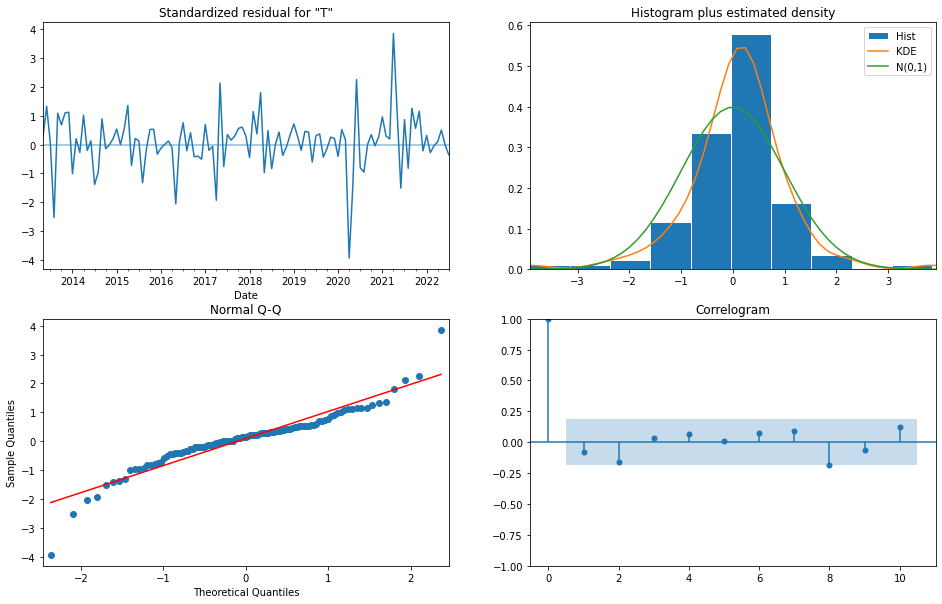

In [115]:
resultados.plot_diagnostics(figsize = (16,10))
plt.show()

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


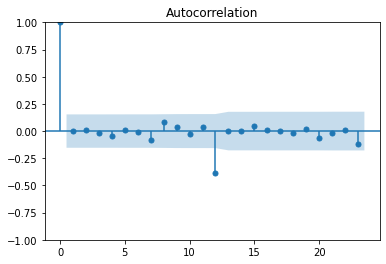

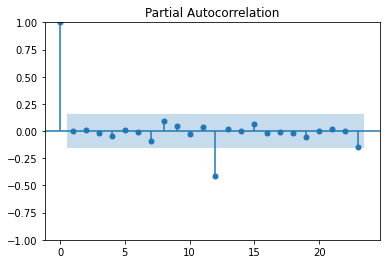

In [116]:
plot_acf(resultados.resid)
plot_pacf(resultados.resid)
plt.show()

# Validación

In [117]:
pred = resultados.get_prediction(start=pd.to_datetime('2022-01-01'),
                                 end=pd.to_datetime('2025-01-01'))
pred.predicted_mean

2022-01-01     88333.567402
2022-02-01     89549.349850
2022-03-01     89543.435403
2022-04-01     90279.110448
2022-05-01     90501.334980
2022-06-01     91171.974670
2022-07-01     92621.415015
2022-08-01     92488.464728
2022-09-01     93880.990480
2022-10-01     94971.768406
2022-11-01     96924.588459
2022-12-01     97398.565648
2023-01-01     98583.126497
2023-02-01     98537.227234
2023-03-01     99005.152645
2023-04-01     97300.561122
2023-05-01     97591.278662
2023-06-01     98507.049938
2023-07-01     98946.516227
2023-08-01     99833.476678
2023-09-01    100599.072896
2023-10-01    101693.767003
2023-11-01    103434.134668
2023-12-01    104122.556360
2024-01-01    105486.435166
2024-02-01    105531.275820
2024-03-01    106076.327878
2024-04-01    105338.185009
2024-05-01    105724.781460
2024-06-01    106373.516243
2024-07-01    107160.593021
2024-08-01    107993.928388
2024-09-01    109034.412280
2024-10-01    110369.621540
2024-11-01    112604.246418
2024-12-01    113280

In [118]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower TotalPet,upper TotalPet
2022-01-01,84128.640185,92538.494618
2022-02-01,85343.407914,93755.291786
2022-03-01,85337.499479,93749.371327
2022-04-01,86077.444965,94480.775931
2022-05-01,86299.672434,94702.997526
2022-06-01,86970.313465,95373.635875
2022-07-01,88419.753817,96823.076213
2022-08-01,88286.803531,96690.125925
2022-09-01,88075.467283,99686.513677
2022-10-01,87987.118485,101956.418327


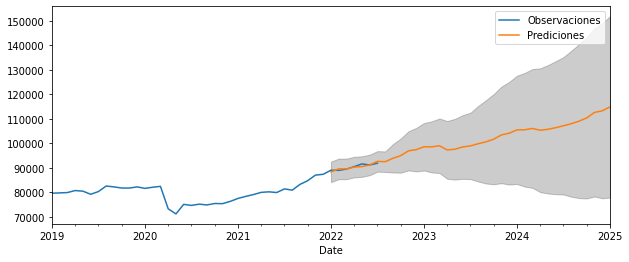

In [120]:
fig = datos.loc['2019-01-01':,'TotalPet'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

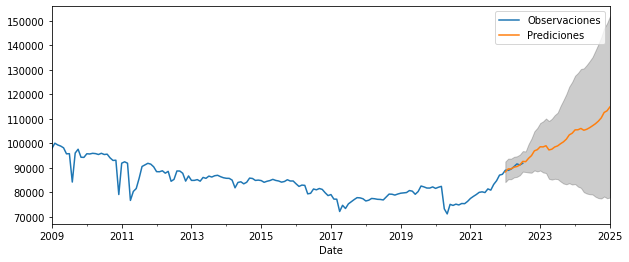

In [121]:
fig = datos.loc['2009-01-01':,'TotalPet'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

In [122]:
y_pred  = pred.predicted_mean
y_real = datos.loc['2020-01-01':'2025-01-01','TotalPet']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 374621.47
La raiz del error cuadrático medio es 612.06


In [123]:
print(f"Porcentaje de error con respecto al promedio: {round(100*np.sqrt(mse)/(datos['TotalPet'].mean()), 3)} %")

Porcentaje de error con respecto al promedio: 0.725 %
